In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

# Camera calibration 

In [30]:
nx, ny = 9, 6 # Expected chessboard features (row x columns)
path_image_cal = 'camera_cal' # Folder containing images for camera calibration
images = glob.glob(path_image_cal + '/*.jpg') # Make a list of calibration images

## Collect data for camera calibration

In [23]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname) # Load the image in BGR 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Do camera calibration given object points and image points

In [588]:
img_size = img.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

## Test image calibration

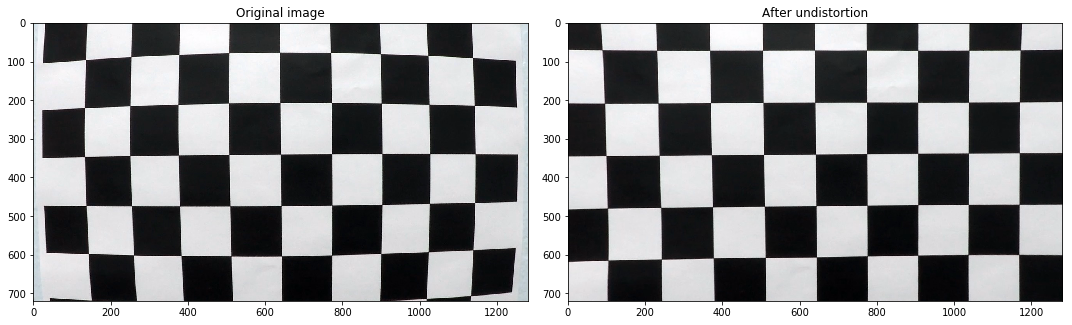

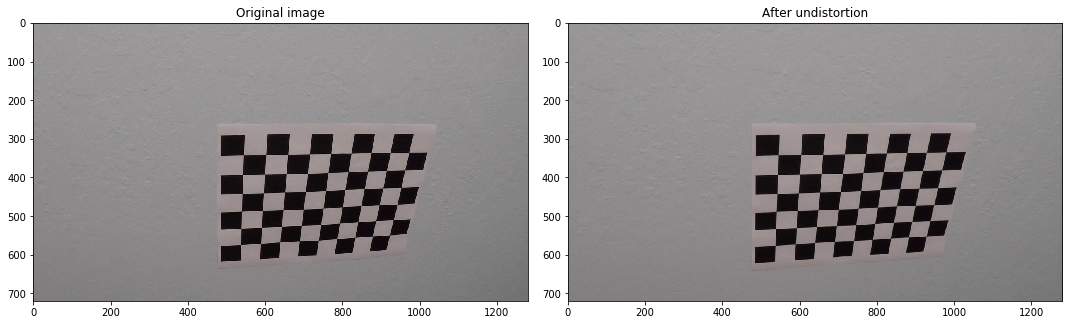

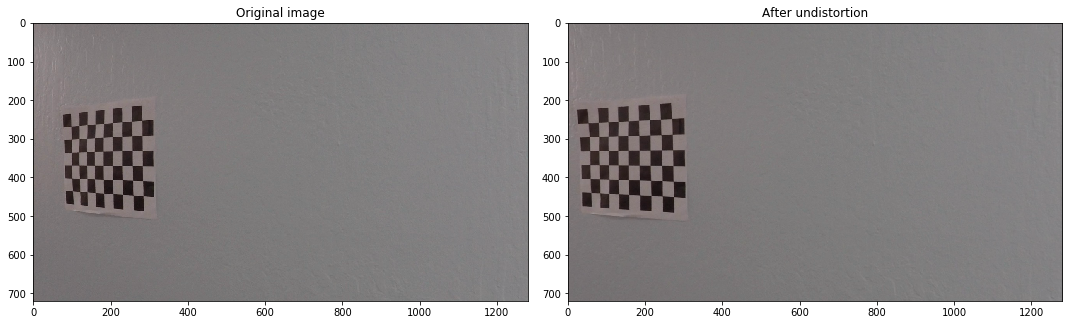

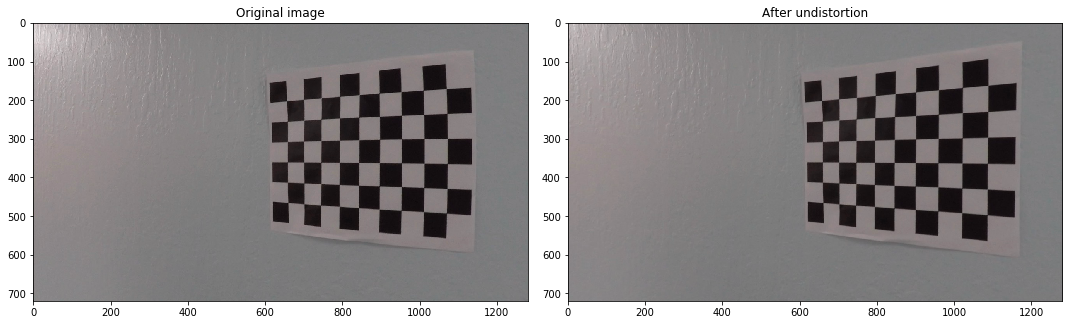

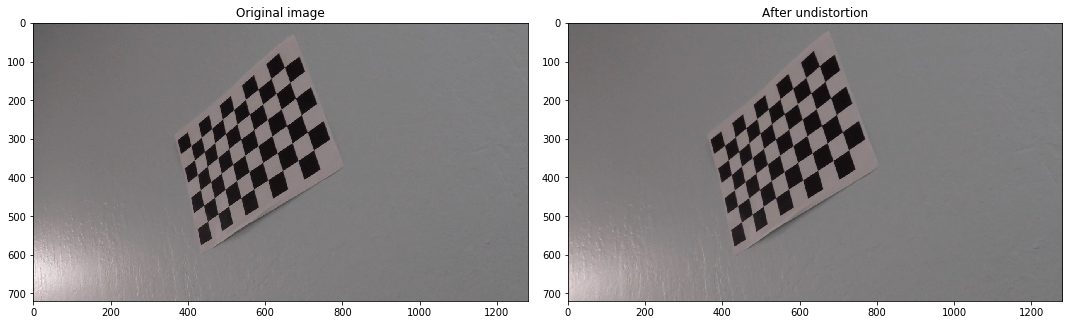

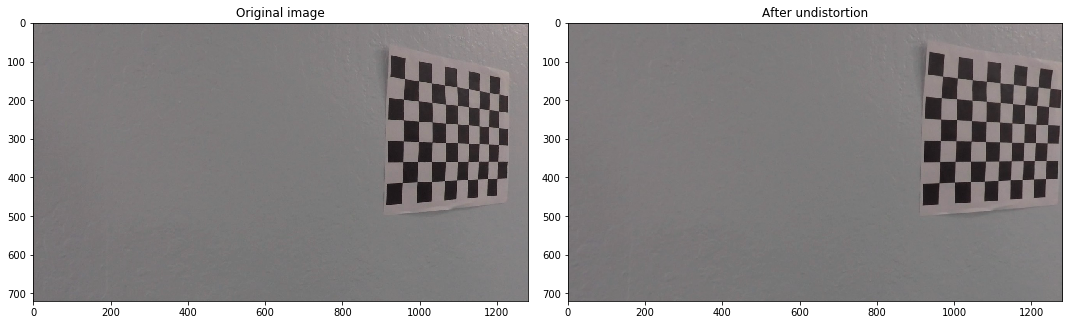

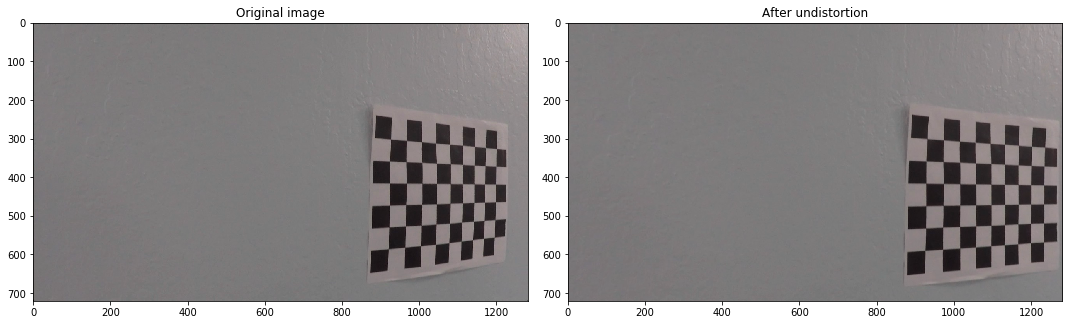

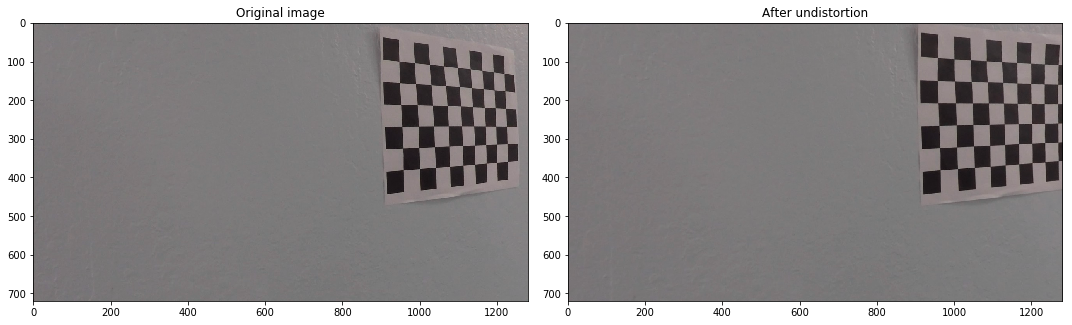

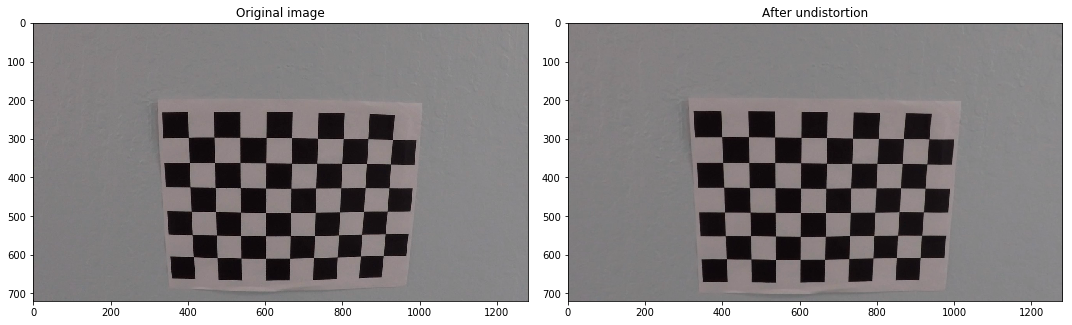

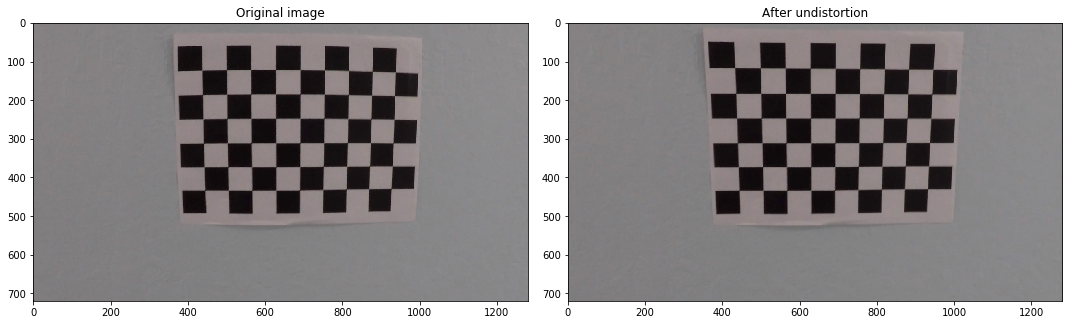

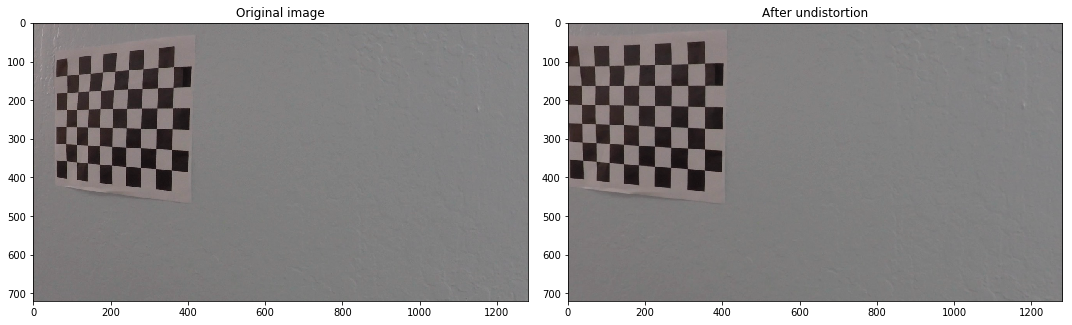

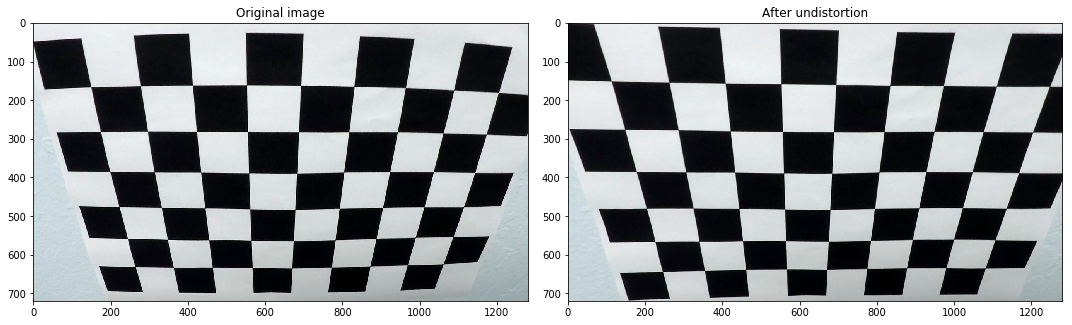

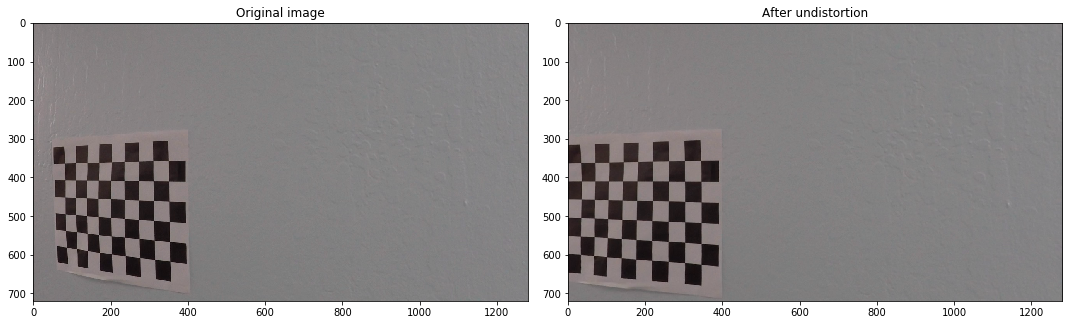

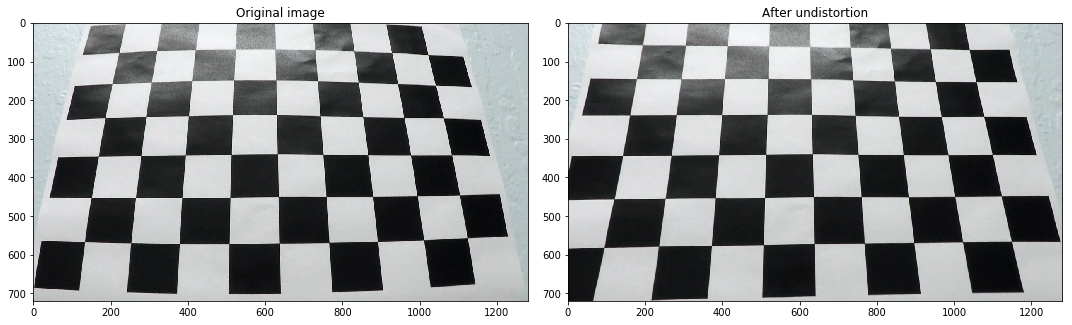

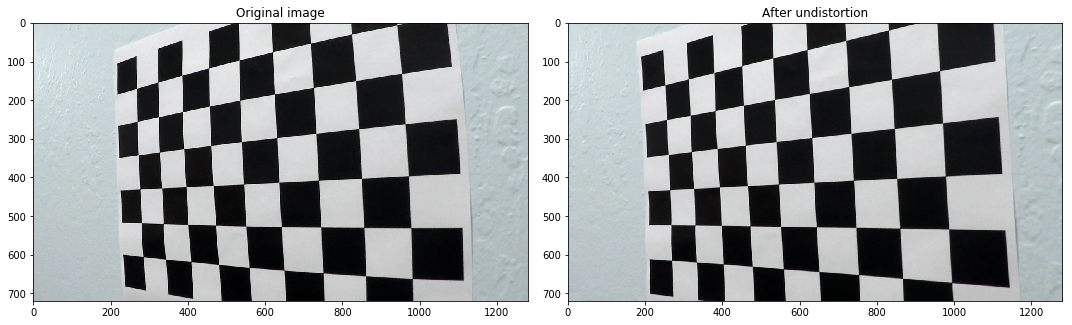

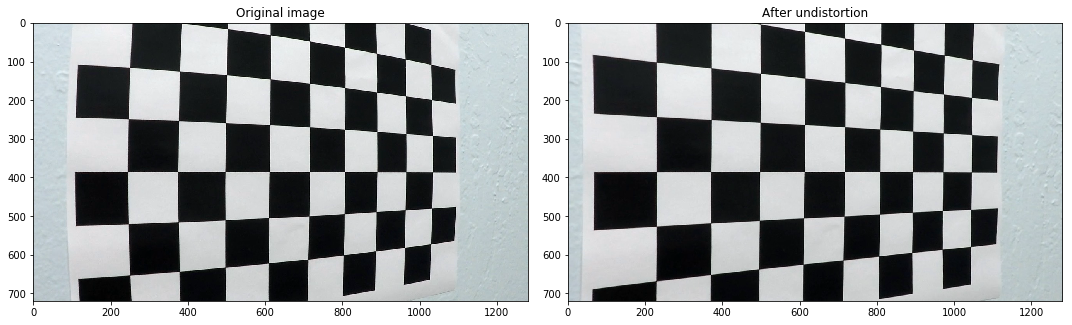

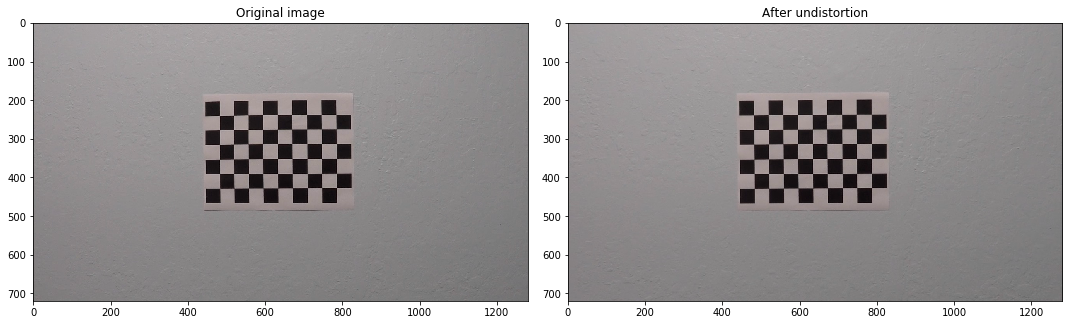

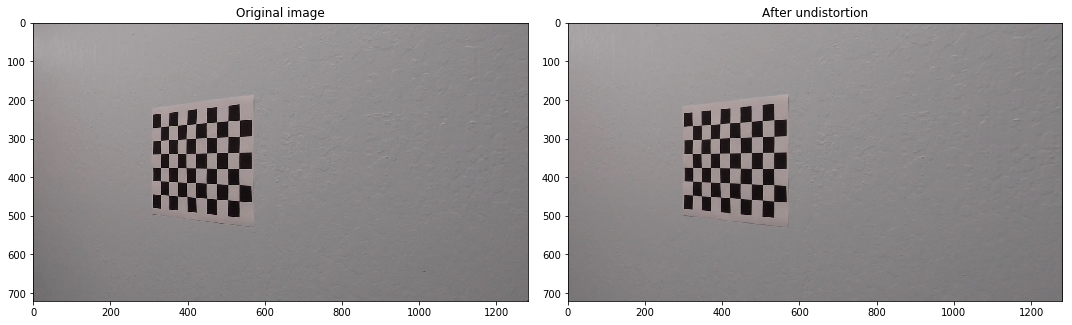

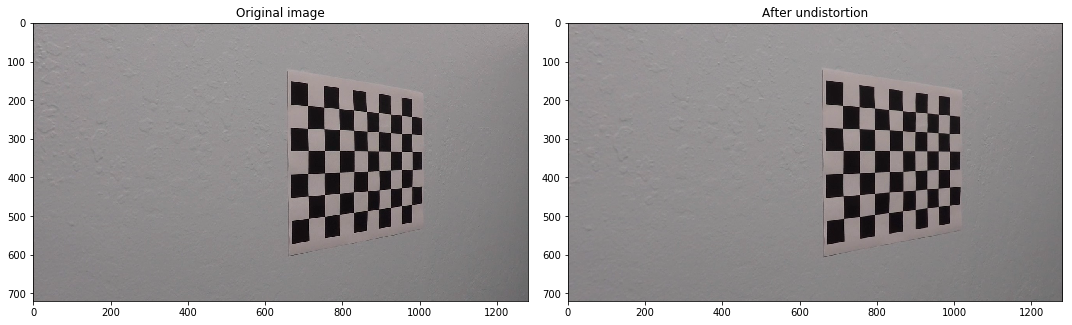

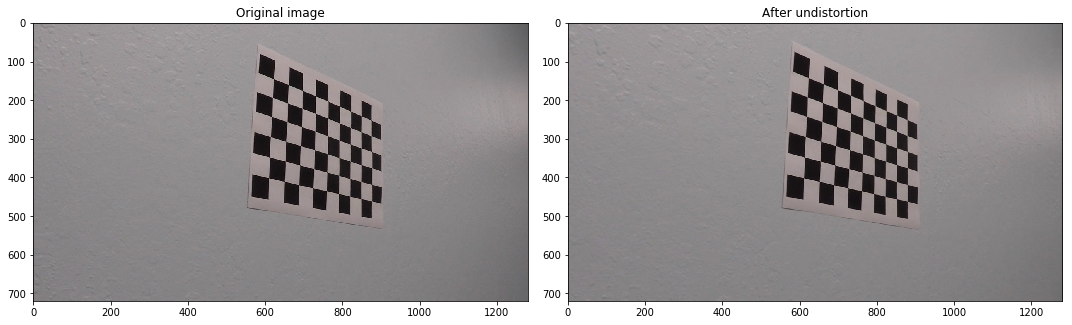

In [589]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname) # Load the image in BGR 
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,30))
    # Draw original image
    ax[0].imshow(img)
    ax[0].set_title('Original image')
    # Draw image after undistortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax[1].imshow(dst)
    ax[1].set_title('After undistortion')
    f.tight_layout()
    plt.show()

## Save camera matrix and distortion coefficient

In [590]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
name_calibration = 'calibration.p' 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( name_calibration, "wb" ) )

# Image binarising pipeline

In [591]:
path_test_images = 'test_images'
test_images = glob.glob(path_test_images+'/*.jpg')

## Pipeline for binarising image

In [683]:
def abs_threshold(chanel, orient='x', abs_thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x' :
        sobel = cv2.Sobel(chanel, cv2.CV_64F, 1, 0)
    elif orient == 'y' :
        sobel = cv2.Sobel(chanel, cv2.CV_64F, 0, 1)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Apply threshold
    mask = np.zeros_like(chanel)
    mask[(scaled_sobel > abs_thresh[0]) & (scaled_sobel < abs_thresh[1])] = 1
    return mask


In [684]:
def mag_threshold(chanel, sobel_kernel = 3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(chanel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(chanel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [685]:
def dir_threshold(chanel, sobel_kernel = 3, dir_thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(chanel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(chanel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [686]:
def combined_binary_pipeline(image, thresholds):
    
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Thresholding
    abs_binary_x = abs_threshold(s_channel, orient='x', abs_thresh=thresholds['abs'])
    abs_binary_y = abs_threshold(s_channel, orient='y', abs_thresh=thresholds['abs'])
    mag_binary = mag_threshold(s_channel, mag_thresh=thresholds['mag'])
    dir_binary = dir_threshold(s_channel, dir_thresh=thresholds['dir'])
    # Combining
    combined = np.zeros_like(dir_binary)
    combined[((abs_binary_x == 1) & (abs_binary_y == 1)) |((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

## Testing the pipeline

In [695]:
thresholds = {'mag':[20,255], 
              'dir':[np.pi/10, np.pi/2],
              'abs':[10,255]
             }

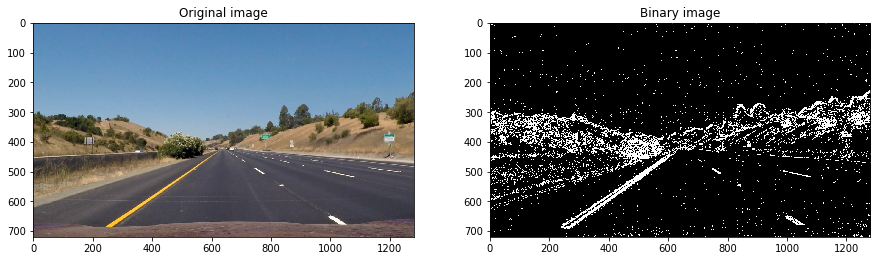

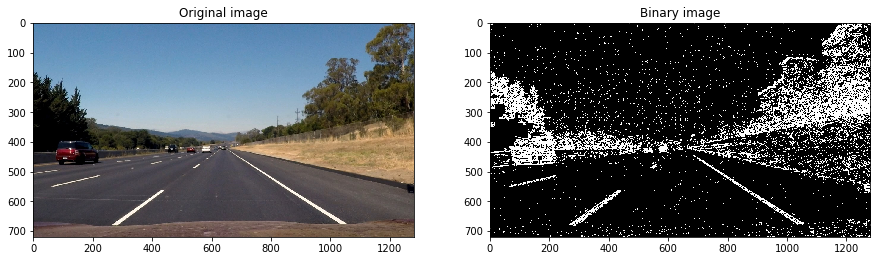

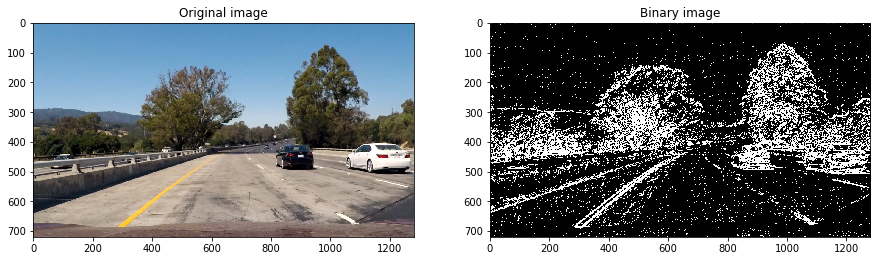

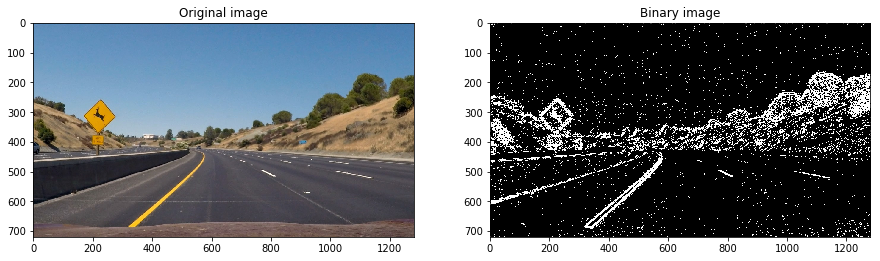

In [696]:
for fname in test_images[:4]:
    img = cv2.imread(fname)
    binary = combined_binary_pipeline(img,thresholds)
    # Plot the result
    f, ax = plt.subplots(1, 2, figsize=(15,30))
    # Draw original image
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
    ax[0].set_title('Original image')
    # Draw image after undistortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax[1].imshow(binary,cmap='gray')
    ax[1].set_title('Binary image')
    

In [519]:
test_images

['test_images/straight_lines1.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

# Perspective transform

In [697]:
straightline_images = glob.glob(path_test_images+'/straight*.jpg')

In [698]:
src = np.float32([[525, 470],
                  [760, 470],
                 [1250, 690],
                  [50, 690]
                 ])

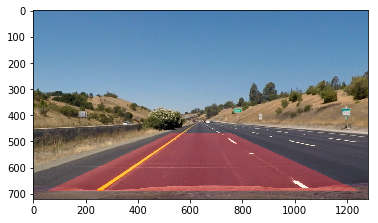

In [699]:
% matplotlib inline
raw = cv2.cvtColor(cv2.imread(straightline_images[0]),cv2.COLOR_BGR2RGB)
undist = undistortion(raw)
msk = np.zeros_like(undist)
cv2.fillPoly(msk,np.int_([src]),color = [255, 0, 0])
to_plot = cv2.addWeighted(raw,1,msk,0.3,0)
plt.imshow(to_plot)

In [700]:
offset = 0
img_size = img.shape[:2]
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

In [722]:
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, (img_size))

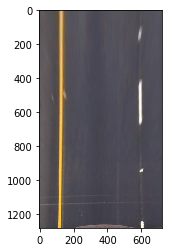

In [704]:
plt.imshow(warped)

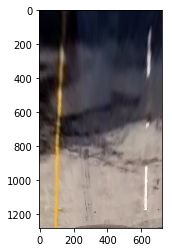

In [719]:
raw = cv2.cvtColor(cv2.imread(test_images[6]),cv2.COLOR_BGR2RGB)
undist = undistortion(raw)
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)

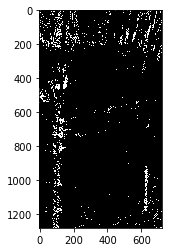

In [720]:
# Load our image
binary_warped = combined_binary_pipeline(warped, thresholds)
plt.imshow(binary_warped, cmap = 'gray')

In [710]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img






In [711]:
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [764]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx , 2)
    right_fit = np.polyfit(righty, rightx , 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, ploty, left_fitx, right_fitx


In [765]:
left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)


In [785]:
image = cv2.cvtColor(cv2.imread(test_images[8]),cv2.COLOR_BGR2RGB)
undist = undistortion(image)
binary = combined_binary_pipeline(undist, thresholds)
binary_warped = cv2.warpPerspective(binary, M, img_size)

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped ).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts[0]]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)


IndexError: list index out of range

In [740]:
color_warp.shape

(1280, 720, 3)

In [368]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [587]:
print(measure_curvature(left_fit,img_size[1]))

13557.9602311


1280

In [ ]:


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

In [579]:
def measure_curvature(line_fit,y_eval):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    curvature = ((1 + (2*line_fit[0]*y_eval*ym_per_pix + line_fit[1])**2)**1.5) / np.absolute(2*line_fit[0])
    return curvature
    
    

In [565]:
! ls

Advanced-line-finding-project.ipynb harder_challenge_video.mp4
LICENSE                             output_images
README.md                           project_video.mp4
calibration.p                       save.p
camera_cal                          set_git.sh
challenge_video.mp4                 test_images
example_writeup.pdf                 writeup_template.md
examples


# Final pipeline

In [566]:
# Load the camera calibration result for later use (we won't worry about rvecs / tvecs) 
calibration  = pickle.load(open('calibration.p', "rb"))
dist = calibration['dist']
mtx = calibration['mtx']

In [567]:
def undistortion(img):
    '''
    This functions return the image after undistortion. Assumes that
    - mtx, camera matrix, exists in the workspace 
    - dist, distortion coefficients vector, exists in the workspace
    '''
    return cv2.undistort(img, mtx, dist, None, mtx)

In [557]:
import pickle
favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump( favorite_color, open( "save.p", "wb" ) )

In [558]:
favorite_color = pickle.load( open( "save.p", "rb" ) )

In [633]:
# TO DO : 
# - Find better parameters
# - Find better combination ? 

# Edit this function to create your own pipeline.
def binary_pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return s_binary